In [1]:
import torch
from tqdm import tqdm
from torch import nn, optim
from torch.nn import init
import pandas as pd
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv("../../data2/data.csv").drop(columns = ["id", "source", 
                                                       "latitude", "longitude"])

In [2]:
class TabularFFNNSimple(nn.Module):
    def __init__(self, input_size, output_size, dropout_prob=0.4):
        super(TabularFFNNSimple, self).__init__()
        hidden_size = 96
        self.ffnn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
#             nn.BatchNorm1d(hidden_size),
            nn.Dropout(0.12),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.12),
            nn.Linear(hidden_size, output_size)
        )
        
        for m in self.ffnn:
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0)

    def forward(self, x):
        x = x.float()
        # print(x)
        x = x.view(x.size(0), -1)
        x = self.ffnn(x)
        return x
    
# Split the data into features and target
X = data.drop('price', axis=1)
y = data['price']

# Standardize the features
device = torch.device("cpu")
# Convert to PyTorch tensors
X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# Split the data into training and combined validation and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
                                                            test_size=0.4, random_state=42)

# Split the combined validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Create DataLoader for training, validation, and testing
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
test_data = TensorDataset(X_test, y_test)

batch_size = 512
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Check if the dimensions match the expected input size for the model
input_size = X_train.shape[1]

# Output
# input_size, train_loader, test_loader

model = TabularFFNNSimple(
    input_size = input_size,
    output_size = 1
)
model.to(device)

num_epochs = 300000
train_losses = []
val_losses = []
epochs_suc = [] # to have a reference to it
grad_norms = []

def get_gradient_norm(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [3]:
optimizer = optim.Adam(
    model.parameters(), 
    lr=9e-3,
    weight_decay=3e-4
)
criterion = torch.nn.MSELoss()
criterion_abs = torch.nn.L1Loss()
criterion = criterion_abs

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.999999, 
    patience=5, 
    verbose=True
)

for epoch in range(num_epochs):
    # Training
    model.train()  # Set the model to training mode
    running_loss = 0.0
    l1_losses = []
    grad_norm = 0
    for tuple_ in train_loader:
        datas, prices = tuple_
        optimizer.zero_grad()
        outputs = model(datas)
        prices_viewed = prices.view(-1, 1).float()
        loss = criterion(outputs, prices_viewed)
        loss.backward()
        grad_norm += get_gradient_norm(model)
        optimizer.step()

        running_loss += loss.item()
        
    grad_norms.append(grad_norm / len(train_loader))
    train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for tuple_ in val_loader:
            datas, prices = tuple_
            outputs = model(datas)  # Forward pass
            prices_viewed = prices.view(-1, 1).float()
            loss = criterion(outputs, prices_viewed)  # Compute loss
            val_loss += loss.item()  # Accumulate the loss
            l1_losses.append(criterion_abs(outputs, prices_viewed))

    val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
    l1_mean_loss = sum(l1_losses) / len(l1_losses)
    # Print epoch's summary
    epochs_suc.append(epoch)
    scheduler.step(val_losses[-1])
    if epoch % 100 == 0:
        tl = f"Training Loss: {int(train_losses[-1])}"
        vl = f"Validation Loss: {int(val_losses[-1])}"
        l1 = f"L1: {int(l1_mean_loss)}"
        dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
        print(dl)

Epoch 1, Training Loss: 233250, Validation Loss: 228811, 17456.150529187587
Epoch 101, Training Loss: 73953, Validation Loss: 73836, 28948.373108368298
Epoch 201, Training Loss: 61695, Validation Loss: 61551, 140596.33993080122
Epoch 301, Training Loss: 59300, Validation Loss: 57201, 87006.52696915202
Epoch 401, Training Loss: 56728, Validation Loss: 59054, 129429.34795989368
Epoch 501, Training Loss: 57860, Validation Loss: 55343, 234188.03060133697
Epoch 601, Training Loss: 53569, Validation Loss: 55342, 50985.01714157101
Epoch 701, Training Loss: 57793, Validation Loss: 54091, 116404.46745236679
Epoch 801, Training Loss: 57410, Validation Loss: 55600, 332747.1361817327
Epoch 901, Training Loss: 52209, Validation Loss: 53687, 114660.22571551609
Epoch 1001, Training Loss: 57330, Validation Loss: 58480, 239714.70771178324
Epoch 1101, Training Loss: 56130, Validation Loss: 54054, 149946.15908990978
Epoch 1201, Training Loss: 49300, Validation Loss: 52739, 121451.42079679314
Epoch 1301, 

Epoch 10701, Training Loss: 45845, Validation Loss: 47570, 187336.8710130529
Epoch 10801, Training Loss: 44053, Validation Loss: 48358, 172412.28410460637
Epoch 10901, Training Loss: 42954, Validation Loss: 47412, 143037.55529044426
Epoch 11001, Training Loss: 43126, Validation Loss: 50677, 293863.22662056395
Epoch 11101, Training Loss: 44148, Validation Loss: 47767, 158546.89231080224
Epoch 11201, Training Loss: 44376, Validation Loss: 49115, 309005.91514381766
Epoch 11301, Training Loss: 41274, Validation Loss: 48240, 123652.95084579696
Epoch 11401, Training Loss: 41099, Validation Loss: 47592, 147291.3442002366
Epoch 11501, Training Loss: 41599, Validation Loss: 48653, 209669.93678778168
Epoch 11601, Training Loss: 40040, Validation Loss: 47853, 174068.03357639656
Epoch 11701, Training Loss: 43290, Validation Loss: 49380, 188271.38363083033
Epoch 11801, Training Loss: 45262, Validation Loss: 46937, 287000.23236623715
Epoch 11901, Training Loss: 39835, Validation Loss: 47581, 125722.

Epoch 21301, Training Loss: 38072, Validation Loss: 50765, 236742.52514017964
Epoch 21401, Training Loss: 44128, Validation Loss: 45698, 337586.7657118381
Epoch 21501, Training Loss: 38913, Validation Loss: 52187, 162826.76538601876
Epoch 21601, Training Loss: 41163, Validation Loss: 50173, 131397.53038999834
Epoch 21701, Training Loss: 40805, Validation Loss: 45701, 193662.8907253174
Epoch 21801, Training Loss: 44256, Validation Loss: 47223, 215102.13083338
Epoch 21901, Training Loss: 38012, Validation Loss: 49346, 181887.52012929335
Epoch 22001, Training Loss: 41168, Validation Loss: 46303, 274937.65708569484
Epoch 22101, Training Loss: 39667, Validation Loss: 47227, 218930.12284168912
Epoch 22201, Training Loss: 41459, Validation Loss: 48583, 166341.32641260215
Epoch 22301, Training Loss: 41701, Validation Loss: 48138, 197255.75315050455
Epoch 22401, Training Loss: 39868, Validation Loss: 46547, 184864.52168508232
Epoch 22501, Training Loss: 39416, Validation Loss: 54680, 175705.783

Epoch 31901, Training Loss: 37996, Validation Loss: 50842, 136001.30707066096
Epoch 32001, Training Loss: 38267, Validation Loss: 46028, 175571.7908906118
Epoch 32101, Training Loss: 35331, Validation Loss: 52030, 191723.54687017435
Epoch 32201, Training Loss: 41002, Validation Loss: 48387, 140838.3423424314
Epoch 32301, Training Loss: 37431, Validation Loss: 54339, 180620.58309950915
Epoch 32401, Training Loss: 37030, Validation Loss: 52989, 141925.94087740182
Epoch 32501, Training Loss: 35496, Validation Loss: 49371, 156917.11798932895
Epoch 32601, Training Loss: 37825, Validation Loss: 47117, 172161.94333311106
Epoch 32701, Training Loss: 35752, Validation Loss: 48795, 167158.02133061553
Epoch 32801, Training Loss: 40354, Validation Loss: 53930, 269934.3437529043
Epoch 32901, Training Loss: 39135, Validation Loss: 49082, 172969.86931125444
Epoch 33001, Training Loss: 37315, Validation Loss: 46689, 209306.78169425912
Epoch 33101, Training Loss: 36135, Validation Loss: 48552, 157111.5

Epoch 42501, Training Loss: 35344, Validation Loss: 51845, 152291.18130822756
Epoch 42601, Training Loss: 37185, Validation Loss: 48982, 147585.51003443406
Epoch 42701, Training Loss: 33492, Validation Loss: 51857, 123745.90335855079
Epoch 42801, Training Loss: 36723, Validation Loss: 51901, 299750.8322783569
Epoch 42901, Training Loss: 34438, Validation Loss: 52593, 195017.18996144083
Epoch 43001, Training Loss: 38405, Validation Loss: 50310, 228142.88384227152
Epoch 43101, Training Loss: 35932, Validation Loss: 48442, 185435.34701315462
Epoch 43201, Training Loss: 38353, Validation Loss: 50595, 153832.41193809197
Epoch 43301, Training Loss: 34674, Validation Loss: 51966, 192461.50610459258
Epoch 43401, Training Loss: 37825, Validation Loss: 54137, 273561.52215507394
Epoch 43501, Training Loss: 35536, Validation Loss: 49962, 143659.73287037687
Epoch 43601, Training Loss: 36006, Validation Loss: 49218, 168048.62993657982
Epoch 43701, Training Loss: 37440, Validation Loss: 50281, 133886

Epoch 53101, Training Loss: 34693, Validation Loss: 54544, 180291.73761322637
Epoch 53201, Training Loss: 33210, Validation Loss: 53129, 151005.55670460852
Epoch 53301, Training Loss: 34601, Validation Loss: 56229, 212016.26467567714
Epoch 53401, Training Loss: 33314, Validation Loss: 52236, 142218.84453684112
Epoch 53501, Training Loss: 34546, Validation Loss: 51135, 147146.84868977786
Epoch 53601, Training Loss: 33796, Validation Loss: 49359, 156322.69198835726
Epoch 53701, Training Loss: 32229, Validation Loss: 56247, 154724.8982347775
Epoch 53801, Training Loss: 33800, Validation Loss: 51159, 181874.76792270213
Epoch 53901, Training Loss: 35801, Validation Loss: 52773, 187956.77493680458
Epoch 54001, Training Loss: 33859, Validation Loss: 52395, 155920.7846761345
Epoch 54101, Training Loss: 35773, Validation Loss: 47821, 221002.83562588706
Epoch 54201, Training Loss: 35528, Validation Loss: 49971, 175508.2414412462
Epoch 54301, Training Loss: 36264, Validation Loss: 54182, 201023.2

Epoch 63701, Training Loss: 32543, Validation Loss: 52031, 168133.39015485471
Epoch 63801, Training Loss: 33885, Validation Loss: 55705, 179309.42573893777
Epoch 63901, Training Loss: 34575, Validation Loss: 51559, 127110.74067591825
Epoch 64001, Training Loss: 34754, Validation Loss: 53587, 173148.81783906082
Epoch 64101, Training Loss: 31347, Validation Loss: 51362, 167928.97138655427
Epoch 64201, Training Loss: 33399, Validation Loss: 49589, 188016.7471435246
Epoch 64301, Training Loss: 32321, Validation Loss: 53298, 168316.18917058758
Epoch 64401, Training Loss: 34218, Validation Loss: 51165, 162534.42990265178
Epoch 64501, Training Loss: 32735, Validation Loss: 50715, 147547.26390520472
Epoch 64601, Training Loss: 31951, Validation Loss: 50280, 165441.80061718458
Epoch 64701, Training Loss: 35069, Validation Loss: 55520, 255289.10587893947
Epoch 64801, Training Loss: 34556, Validation Loss: 53155, 202767.16612736788
Epoch 64901, Training Loss: 31306, Validation Loss: 53855, 146416

Epoch 74301, Training Loss: 29822, Validation Loss: 55995, 242218.24881535638
Epoch 74401, Training Loss: 31917, Validation Loss: 56615, 160740.85548081025
Epoch 74501, Training Loss: 32227, Validation Loss: 52270, 150372.88137667548
Epoch 74601, Training Loss: 32176, Validation Loss: 51763, 123767.37895235517
Epoch 74701, Training Loss: 30079, Validation Loss: 55644, 124461.75858944852
Epoch 74801, Training Loss: 32979, Validation Loss: 51641, 193567.2319815505
Epoch 74901, Training Loss: 30171, Validation Loss: 52998, 135364.33186624598
Epoch 75001, Training Loss: 31241, Validation Loss: 53695, 122741.82086875923
Epoch 75101, Training Loss: 31340, Validation Loss: 53612, 128766.49135170633
Epoch 75201, Training Loss: 35646, Validation Loss: 55668, 209947.91605213983
Epoch 75301, Training Loss: 32377, Validation Loss: 52738, 169303.73859193132
Epoch 75401, Training Loss: 30615, Validation Loss: 54941, 150163.53166451945
Epoch 75501, Training Loss: 33896, Validation Loss: 51454, 135466

Epoch 84901, Training Loss: 31903, Validation Loss: 53062, 210075.51820409615
Epoch 85001, Training Loss: 29693, Validation Loss: 54748, 130894.69661750749
Epoch 85101, Training Loss: 33241, Validation Loss: 57684, 160151.75511263902
Epoch 85201, Training Loss: 31335, Validation Loss: 53168, 134307.50306098102
Epoch 85301, Training Loss: 32140, Validation Loss: 53518, 195870.5886389745
Epoch 85401, Training Loss: 30813, Validation Loss: 54013, 163069.00586405746
Epoch 85501, Training Loss: 31080, Validation Loss: 51522, 103386.73332268454
Epoch 85601, Training Loss: 33097, Validation Loss: 54570, 151492.06909740844
Epoch 85701, Training Loss: 29387, Validation Loss: 53761, 164245.073663038
Epoch 85801, Training Loss: 33641, Validation Loss: 53568, 167158.61699603393
Epoch 85901, Training Loss: 33692, Validation Loss: 51632, 225937.0311572854
Epoch 86001, Training Loss: 29791, Validation Loss: 53850, 189886.56667690605
Epoch 86101, Training Loss: 30829, Validation Loss: 51309, 163801.75

Epoch 95501, Training Loss: 32350, Validation Loss: 53654, 117781.53213657986
Epoch 95601, Training Loss: 32131, Validation Loss: 52246, 161602.67840943238
Epoch 95701, Training Loss: 33275, Validation Loss: 52474, 215603.12570602182
Epoch 95801, Training Loss: 31504, Validation Loss: 53437, 182077.48155055815
Epoch 95901, Training Loss: 30661, Validation Loss: 54536, 162065.49165751672
Epoch 96001, Training Loss: 30243, Validation Loss: 56265, 156405.6582478936
Epoch 96101, Training Loss: 31820, Validation Loss: 55118, 167601.44543924314
Epoch 96201, Training Loss: 30806, Validation Loss: 52215, 151653.206237699
Epoch 96301, Training Loss: 32468, Validation Loss: 52528, 160726.3010554154
Epoch 96401, Training Loss: 30669, Validation Loss: 55887, 140951.00679701814
Epoch 96501, Training Loss: 29286, Validation Loss: 57552, 155635.56919250544
Epoch 96601, Training Loss: 28488, Validation Loss: 52744, 138888.4112147947
Epoch 96701, Training Loss: 31063, Validation Loss: 51434, 158148.907

Epoch 106001, Training Loss: 28559, Validation Loss: 51612, 139906.87735261905
Epoch 106101, Training Loss: 31171, Validation Loss: 53042, 196810.64901557832
Epoch 106201, Training Loss: 30701, Validation Loss: 52254, 149089.7897214862
Epoch 106301, Training Loss: 30095, Validation Loss: 52131, 144092.460064541
Epoch 106401, Training Loss: 31199, Validation Loss: 55242, 136015.70211341218
Epoch 106501, Training Loss: 31141, Validation Loss: 51964, 133911.74199611883
Epoch 106601, Training Loss: 30984, Validation Loss: 52181, 204363.98778296448
Epoch 106701, Training Loss: 30022, Validation Loss: 52954, 153918.0227136555
Epoch 106801, Training Loss: 28642, Validation Loss: 54407, 139173.06025359267
Epoch 106901, Training Loss: 32315, Validation Loss: 52095, 149237.61187192946
Epoch 107001, Training Loss: 30210, Validation Loss: 51329, 122147.86776811664
Epoch 107101, Training Loss: 30938, Validation Loss: 57447, 138147.87992097728
Epoch 107201, Training Loss: 31836, Validation Loss: 541

Epoch 116501, Training Loss: 31729, Validation Loss: 55282, 170260.67569353766
Epoch 116601, Training Loss: 30182, Validation Loss: 53261, 214683.92795259404
Epoch 116701, Training Loss: 29723, Validation Loss: 55854, 117635.03809427684
Epoch 116801, Training Loss: 28502, Validation Loss: 54203, 125832.5119888517
Epoch 116901, Training Loss: 29559, Validation Loss: 53167, 144236.42692221873
Epoch 117001, Training Loss: 29410, Validation Loss: 53372, 188057.52913354596
Epoch 117101, Training Loss: 29859, Validation Loss: 57009, 191796.68837639104
Epoch 117201, Training Loss: 29881, Validation Loss: 52054, 179898.9960859093
Epoch 117301, Training Loss: 28425, Validation Loss: 52782, 127488.8965217123
Epoch 117401, Training Loss: 28746, Validation Loss: 54928, 175148.5997919235
Epoch 117501, Training Loss: 30381, Validation Loss: 55309, 173166.32695024597
Epoch 117601, Training Loss: 29099, Validation Loss: 55840, 146818.10312889682
Epoch 117701, Training Loss: 27955, Validation Loss: 556

Epoch 127001, Training Loss: 31713, Validation Loss: 54141, 126021.00269063213
Epoch 127101, Training Loss: 30430, Validation Loss: 56705, 183681.81034868126
Epoch 127201, Training Loss: 28324, Validation Loss: 54880, 126223.23353112547
Epoch 127301, Training Loss: 32972, Validation Loss: 50325, 154882.09074066192
Epoch 127401, Training Loss: 29676, Validation Loss: 54346, 154585.13316911925
Epoch 127501, Training Loss: 27493, Validation Loss: 51091, 110494.91933415529
Epoch 127601, Training Loss: 29468, Validation Loss: 52919, 247489.30355575992
Epoch 127701, Training Loss: 30597, Validation Loss: 54621, 161965.96131365316
Epoch 127801, Training Loss: 30996, Validation Loss: 51172, 150473.57792006715
Epoch 127901, Training Loss: 32111, Validation Loss: 52135, 160208.11058939478
Epoch 128001, Training Loss: 29820, Validation Loss: 55139, 150138.99824832228
Epoch 128101, Training Loss: 29251, Validation Loss: 52860, 172864.55426016677
Epoch 128201, Training Loss: 28347, Validation Loss:

Epoch 137401, Training Loss: 29760, Validation Loss: 53982, 159510.16919462127
Epoch 137501, Training Loss: 29086, Validation Loss: 55584, 138715.85285746807
Epoch 137601, Training Loss: 29091, Validation Loss: 55421, 139567.410347921
Epoch 137701, Training Loss: 27293, Validation Loss: 54609, 147623.08893144052
Epoch 137801, Training Loss: 31480, Validation Loss: 55325, 200894.83531995388
Epoch 137901, Training Loss: 30884, Validation Loss: 50579, 122720.46126822848
Epoch 138001, Training Loss: 30096, Validation Loss: 52767, 127715.84081642081
Epoch 138101, Training Loss: 30773, Validation Loss: 53423, 176367.53755237488
Epoch 138201, Training Loss: 29741, Validation Loss: 56487, 169688.7749607557
Epoch 138301, Training Loss: 28975, Validation Loss: 51354, 152158.32419379358
Epoch 138401, Training Loss: 29303, Validation Loss: 54833, 166447.3601229379
Epoch 138501, Training Loss: 29513, Validation Loss: 50995, 173976.2490140208
Epoch 138601, Training Loss: 30408, Validation Loss: 5300

Epoch 147901, Training Loss: 28368, Validation Loss: 54446, 136961.08810596648
Epoch 148001, Training Loss: 27725, Validation Loss: 52256, 143907.58313993912
Epoch 148101, Training Loss: 32023, Validation Loss: 51014, 162433.1575421498
Epoch 148201, Training Loss: 28916, Validation Loss: 53975, 123161.65167185622
Epoch 148301, Training Loss: 30112, Validation Loss: 54924, 198480.47976249724
Epoch 148401, Training Loss: 29573, Validation Loss: 53908, 181797.0783857743
Epoch 148501, Training Loss: 32081, Validation Loss: 52240, 225485.79284240934
Epoch 148601, Training Loss: 27352, Validation Loss: 54021, 126638.28746232996
Epoch 148701, Training Loss: 27475, Validation Loss: 53986, 116131.45552831875
Epoch 148801, Training Loss: 27233, Validation Loss: 54088, 145943.77683837523
Epoch 148901, Training Loss: 31571, Validation Loss: 54032, 186577.0771565749
Epoch 149001, Training Loss: 30468, Validation Loss: 53548, 151747.14888485704
Epoch 149101, Training Loss: 29349, Validation Loss: 55

Epoch 158401, Training Loss: 28284, Validation Loss: 53002, 114901.24211986503
Epoch 158501, Training Loss: 29153, Validation Loss: 54502, 171780.07614342935
Epoch 158601, Training Loss: 31235, Validation Loss: 52791, 138004.76894016707
Epoch 158701, Training Loss: 29370, Validation Loss: 53413, 190820.08192162646
Epoch 158801, Training Loss: 28761, Validation Loss: 54813, 186073.54255245754
Epoch 158901, Training Loss: 28518, Validation Loss: 53320, 123393.17413775489
Epoch 159001, Training Loss: 29527, Validation Loss: 52837, 137536.84108051754
Epoch 159101, Training Loss: 26978, Validation Loss: 57324, 132934.62835840904
Epoch 159201, Training Loss: 28662, Validation Loss: 55303, 160729.41734236397
Epoch 159301, Training Loss: 31459, Validation Loss: 53850, 227871.2936412726
Epoch 159401, Training Loss: 27963, Validation Loss: 54656, 94561.72003218836
Epoch 159501, Training Loss: 31243, Validation Loss: 52366, 228752.71672378512
Epoch 159601, Training Loss: 27495, Validation Loss: 5

Epoch 168901, Training Loss: 27347, Validation Loss: 49958, 133637.9732865301
Epoch 169001, Training Loss: 28724, Validation Loss: 51893, 150755.69344135534
Epoch 169101, Training Loss: 27384, Validation Loss: 54519, 148400.99995436767
Epoch 169201, Training Loss: 28154, Validation Loss: 51751, 166214.35581082208
Epoch 169301, Training Loss: 27876, Validation Loss: 53633, 118978.25516246837
Epoch 169401, Training Loss: 28227, Validation Loss: 56086, 137965.16269962146
Epoch 169501, Training Loss: 29905, Validation Loss: 50906, 132261.09955344655
Epoch 169601, Training Loss: 28797, Validation Loss: 50959, 119585.9415152227
Epoch 169701, Training Loss: 28029, Validation Loss: 50453, 147015.29574213602
Epoch 169801, Training Loss: 28056, Validation Loss: 53487, 129528.10163274048
Epoch 169901, Training Loss: 31017, Validation Loss: 54073, 154072.88705681864
Epoch 170001, Training Loss: 29008, Validation Loss: 53812, 172224.1661383521
Epoch 170101, Training Loss: 30393, Validation Loss: 53

Epoch 179401, Training Loss: 29212, Validation Loss: 54009, 138013.6275287757
Epoch 179501, Training Loss: 27812, Validation Loss: 52222, 144235.57268055037
Epoch 179601, Training Loss: 28374, Validation Loss: 54716, 145596.99847933775
Epoch 179701, Training Loss: 26762, Validation Loss: 55173, 132161.08083667766
Epoch 179801, Training Loss: 28455, Validation Loss: 53953, 163341.06138524134
Epoch 179901, Training Loss: 28801, Validation Loss: 52636, 121017.50222677847
Epoch 180001, Training Loss: 26923, Validation Loss: 51298, 161044.18758280206
Epoch 180101, Training Loss: 27401, Validation Loss: 54697, 149796.29571798182
Epoch 180201, Training Loss: 32170, Validation Loss: 52833, 165210.85846996953
Epoch 180301, Training Loss: 28139, Validation Loss: 51739, 156832.3416942556
Epoch 180401, Training Loss: 29840, Validation Loss: 54169, 113171.78678983815
Epoch 180501, Training Loss: 29472, Validation Loss: 50149, 180052.54229523847
Epoch 180601, Training Loss: 30676, Validation Loss: 5

Epoch 189901, Training Loss: 31190, Validation Loss: 51868, 171221.9654597651
Epoch 190001, Training Loss: 29000, Validation Loss: 51270, 171995.24860240682
Epoch 190101, Training Loss: 27372, Validation Loss: 54761, 137202.0983364009
Epoch 190201, Training Loss: 29219, Validation Loss: 53728, 162407.23558702035
Epoch 190301, Training Loss: 28212, Validation Loss: 53195, 161404.529010482
Epoch 190401, Training Loss: 29927, Validation Loss: 55532, 272009.43155824445
Epoch 190501, Training Loss: 30499, Validation Loss: 55289, 128769.76500115874
Epoch 190601, Training Loss: 27549, Validation Loss: 56388, 137987.56053929596
Epoch 190701, Training Loss: 26864, Validation Loss: 55595, 127097.74928895973
Epoch 190801, Training Loss: 27926, Validation Loss: 53081, 114101.30956790618
Epoch 190901, Training Loss: 29217, Validation Loss: 50825, 183729.81295057666
Epoch 191001, Training Loss: 26879, Validation Loss: 53467, 137199.3576285741
Epoch 191101, Training Loss: 29225, Validation Loss: 5276

Epoch 200401, Training Loss: 28310, Validation Loss: 51903, 153920.93376236226
Epoch 200501, Training Loss: 30390, Validation Loss: 57683, 194607.37751750267
Epoch 200601, Training Loss: 27870, Validation Loss: 53108, 146645.2765614007
Epoch 200701, Training Loss: 28516, Validation Loss: 54150, 221881.1901490478
Epoch 200801, Training Loss: 27725, Validation Loss: 52367, 159466.1414081483
Epoch 200901, Training Loss: 28085, Validation Loss: 56234, 177730.0584667297
Epoch 201001, Training Loss: 30443, Validation Loss: 53883, 182619.25262686028
Epoch 201101, Training Loss: 27459, Validation Loss: 56162, 151554.02257054372
Epoch 201201, Training Loss: 28275, Validation Loss: 53468, 117715.07776935505
Epoch 201301, Training Loss: 29720, Validation Loss: 53767, 151177.476785825
Epoch 201401, Training Loss: 26972, Validation Loss: 53083, 165167.83411013152
Epoch 201501, Training Loss: 28469, Validation Loss: 52467, 158596.64855544866
Epoch 201601, Training Loss: 26611, Validation Loss: 53117

KeyboardInterrupt: 

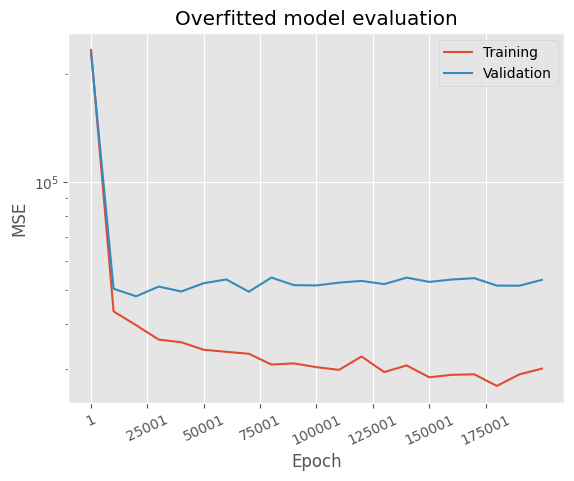

In [5]:
import matplotlib.pyplot as plt

train_losses_sampled = train_losses[::10000]  # Select every 1000th value
val_losses_sampled = val_losses[::10000]      # Select every 1000th value

# Generate corresponding epoch numbers, assuming epochs_suc is your list of epoch numbers
epochs_sampled = epochs_suc[::10000]

plt.style.use("ggplot")
plt.title("Overfitted model evaluation")


# Use sampled data for plotting
plt.plot(epochs_sampled, train_losses_sampled, label='Training')
plt.plot(epochs_sampled, val_losses_sampled, label='Validation')

plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.yscale('log')
plt.xticks(
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    range(1, epochs_sampled[-1], int(epochs_sampled[-1] / 8)),
    rotation = 25
)
plt.legend()
plt.show()
# plt.savefig("../visualizations/overfit_model_evaluation_full_dataset.png", dpi=800)

# Saving. Good results

In [ ]:
# class TabularFFNNSimple(nn.Module):
#     def __init__(self, input_size, output_size, dropout_prob=0.4):
#         super(TabularFFNNSimple, self).__init__()
#         hidden_size = 48
#         self.ffnn = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
# #             nn.BatchNorm1d(hidden_size),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
# #             nn.Dropout(0.5),
#             nn.Linear(hidden_size, output_size)
#         )
        
#         for m in self.ffnn:
#             if isinstance(m, nn.Linear):
#                 init.xavier_uniform_(m.weight)
#                 m.bias.data.fill_(0)

#     def forward(self, x):
#         x = x.float()
#         # print(x)
#         x = x.view(x.size(0), -1)
#         x = self.ffnn(x)
#         return x
    
# # Split the data into features and target
# X = data.drop('price', axis=1)
# y = data['price']

# # Standardize the features
# device = torch.device("cpu")
# # Convert to PyTorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32, device = device)
# y_tensor = torch.tensor(y.values, dtype=torch.float32, device = device)


# # Split the data into training and combined validation and testing sets
# X_train, X_val_test, y_train, y_val_test = train_test_split(X_tensor, y_tensor,
#                                                             test_size=0.4, random_state=42)

# # Split the combined validation and testing sets
# X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# # Create DataLoader for training, validation, and testing
# train_data = TensorDataset(X_train, y_train)
# val_data = TensorDataset(X_val, y_val)
# test_data = TensorDataset(X_test, y_test)

# batch_size = 256
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# # Check if the dimensions match the expected input size for the model
# input_size = X_train.shape[1]

# # Output
# # input_size, train_loader, test_loader

# model = TabularFFNNSimple(
#     input_size = input_size,
#     output_size = 1
# )
# model.to(device)

# num_epochs = 300000
# train_losses = []
# val_losses = []
# epochs_suc = [] # to have a reference to it
# grad_norms = []

# def get_gradient_norm(model):
#     total_norm = 0
#     for p in model.parameters():
#         if p.grad is not None:
#             param_norm = p.grad.data.norm(2)
#             total_norm += param_norm.item() ** 2
#     total_norm = total_norm ** 0.5
#     return total_norm

# optimizer = optim.Adam(
#     model.parameters(), 
#     lr=9e-3,
#     weight_decay=1e-4
# )
# criterion = torch.nn.MSELoss()
# criterion_abs = torch.nn.L1Loss()
# criterion = criterion_abs

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, 
#     mode='min', 
#     factor=0.999999, 
#     patience=10, 
#     verbose=True
# )

# for epoch in range(num_epochs):
#     # Training
#     model.train()  # Set the model to training mode
#     running_loss = 0.0
#     l1_losses = []
#     grad_norm = 0
#     for tuple_ in train_loader:
#         datas, prices = tuple_
#         optimizer.zero_grad()
#         outputs = model(datas)
#         prices_viewed = prices.view(-1, 1).float()
#         loss = criterion(outputs, prices_viewed)
#         loss.backward()
#         grad_norm += get_gradient_norm(model)
#         optimizer.step()

#         running_loss += loss.item()
        
#     grad_norms.append(grad_norm / len(train_loader))
#     train_losses.append(running_loss / len(train_loader))  # Average loss for this epoch

#     # Validation
#     model.eval()  # Set the model to evaluation mode
#     val_loss = 0.0
#     with torch.no_grad():  # Disable gradient calculation
#         for tuple_ in val_loader:
#             datas, prices = tuple_
#             outputs = model(datas)  # Forward pass
#             prices_viewed = prices.view(-1, 1).float()
#             loss = criterion(outputs, prices_viewed)  # Compute loss
#             val_loss += loss.item()  # Accumulate the loss
#             l1_losses.append(criterion_abs(outputs, prices_viewed))

#     val_losses.append(val_loss / len(val_loader))  # Average loss for this epoch
#     l1_mean_loss = sum(l1_losses) / len(l1_losses)
#     # Print epoch's summary
#     epochs_suc.append(epoch)
#     scheduler.step(val_losses[-1])
#     if epoch % 100 == 0:
#         tl = f"Training Loss: {int(train_losses[-1])}"
#         vl = f"Validation Loss: {int(val_losses[-1])}"
#         l1 = f"L1: {int(l1_mean_loss)}"
#         dl = f'Epoch {epoch+1}, {tl}, {vl}, {grad_norms[-1]}'
#         print(dl)